In [5]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import multiset
import random
import scipy.stats

import tqdm.notebook
import collections
import sortedcontainers

from statsmodels.distributions.empirical_distribution import ECDF

In [2]:
orig_points = pd.read_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/points.txt", sep="\s+")
counts = pd.read_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/counts.txt", sep="\s+")
min_dist = counts.value.iloc[1]

Text(0, 0.5, 'Count')

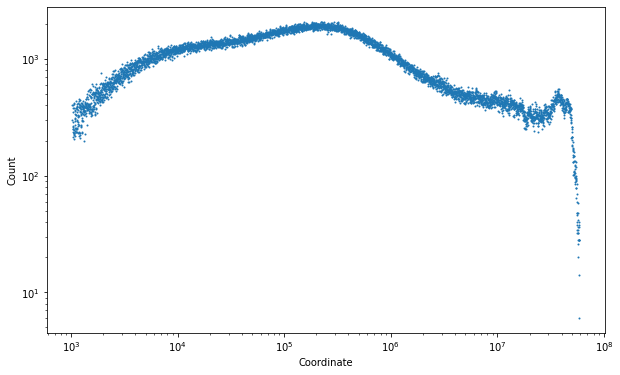

In [3]:
plt.figure(figsize=(10,6))
plt.plot(
    counts.value,
    counts.p,
    '.',
    ms=2
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coordinate")
plt.ylabel("Count")

In [ ]:
# class CoordinateMapper(object):
#     def __init__(self, points):
#         # List of all current coords        
#         self.coords = points.ravel()
#         self.max = self.coords.max()
                
#         # Inverse multimap
#         self.inverse_map = [[] for i in tqdm.notebook.trange(self.max+1)]
#         for i, coord in enumerate(tqdm.notebook.tqdm(self.coords)):
#             self.inverse_map[coord].append(i)
        
#         # Pointers to next larger
#         self.next_larger = np.zeros(self.max+1, dtype=int)
#         last = -1
#         for i in tqdm.notebook.trange(self.max, -1, -1):
#             if len(self.inverse_map[i]) == 0:
#                 self.next_larger[i] = last
#             else:
#                 self.next_larger[i] = i
#                 last = i
                
#         # Pointers to next smaller
#         self.next_smaller = np.zeros(self.max+1, dtype=int)
#         last = -1
#         for i in tqdm.notebook.trange(self.max+1):
#             if len(self.inverse_map[i]) == 0:
#                 self.next_smaller[i] = last
#             else:
#                 self.next_smaller[i] = i
#                 last = i
    
#     def sample_coordinate(self):
#         return random.choice(self.coords)
    
#     def remove(self, coordinate):
#         # Update inverse map and coords
#         assert len(self.inverse_map[coordinate]) > 0
#         pos = self.inverse_map[coordinate].pop()
        
#         if pos == len(self.coords)-1:
#             self.coords = self.coords[:-1]
#         else:
#             lst = self.inverse_map[self.coords[-1]]
#             lst.pop(lst.index(len(self.coords)-1))
#             lst.append(pos)
            
#             self.coords[pos] = self.coords[-1]
#             self.coords = self.coords[:-1]
            
#         # Update next larger and next smaller
#         if len(self.inverse_map[coordinate]) == 0:
#             # Next larger
#             if coordinate+1 <= self.max:
#                 next_ptr = self.next_larger[coordinate+1]
#             else:
#                 next_ptr = -1
            
#             pos = coordinate
#             while pos >= 0 and self.next_larger[pos] == coordinate:
#                 self.next_larger[pos] = next_ptr
#                 pos -= 1
                
#             # Next smaller
#             if coordinate-1 >= 0:
#                 next_ptr = self.next_smaller[coordinate-1]
#             else:
#                 next_ptr = -1
            
#             pos = coordinate
#             while pos <= self.max and self.next_smaller[pos] == coordinate:
#                 self.next_smaller[pos] = next_ptr
#                 pos += 1
            
    
#     def get_next_larger(self, position):
#         return self.next_larger[position]
    
#     def get_next_smaller(self, position):
#         return self.next_smaller[position]

In [95]:
class SortedCoordinateMapper(object):
    def __init__(self, points):
        self.max = np.array(points).max()        
        self.coords = sortedcontainers.SortedList(np.array(points).ravel())
        self.n_coords = len(self.coords)
    
    def sample_coordinate(self):
        return self.coords[np.random.choice(len(self.coords))]
    
    def remove(self, coordinate):
        self.coords.remove(coordinate)
    
    def get_next_larger(self, position):
        x = self.coords.bisect_left(position)
        if x == len(self.coords):
            return -1
        else:
            return self.coords[x]
    
    def get_next_smaller(self, position):
        x = self.coords.bisect_right(position)
        if x == 0:
            return -1
        else:
            return self.coords[x-1]
    
# small_points = (orig_points.values).astype(int)
# CM = SortedCoordinateMapper(small_points)

In [96]:
class DiagonalSampler(object):
    def __init__(self, points, min_dist):
        self.n_points = points.shape[0]
        self.diagonals = np.abs(np.diff(points, axis=1)).astype(int).ravel()
        self.mapper = SortedCoordinateMapper(points.astype(int))
        self.max = self.mapper.max
        self.min_dist = min_dist
        
    def build(self):
        new_points = []
        
        for n_point in tqdm.notebook.trange(self.n_points):            
            best_y = np.inf
            
            while True:
                x = self.mapper.sample_coordinate()
                d = random.choice(self.diagonals)



                candidates = []
                if x+d <= self.max:
                    candidates.extend([self.mapper.get_next_larger(x+d), self.mapper.get_next_smaller(x+d)])
                if 0<= x-d:
                    candidates.extend([self.mapper.get_next_larger(x-d), self.mapper.get_next_smaller(x-d)])
                    
                random.shuffle(candidates)

                for y in candidates:
                    if y != -1 and \
                        y != x and \
                        np.abs(np.abs(y-x)-d) < np.abs(np.abs(best_y-x)-d):
                        best_y = y
                    
                if best_y != np.inf:
                    break
                    
            assert best_y in self.mapper.coords
            new_points.append(list(sorted([x, best_y])))
            self.mapper.remove(x)
            self.mapper.remove(best_y)
            
        self.new_points = np.array(new_points)
    
    def fix(self):
        for n_point in tqdm.notebook.trange(self.n_points):
            while np.abs(self.new_points[n_point, 1] - self.new_points[n_point, 0]) < self.min_dist:
                j = np.random.choice(self.n_points)
                if np.abs(self.new_points[n_point, 0] - self.new_points[j, 1]) >= self.min_dist and \
                    np.abs(self.new_points[n_point, 1] - self.new_points[j, 0]) >= self.min_dist:
                    self.new_points[n_point, 1], self.new_points[j, 1] = self.new_points[j, 1], self.new_points[n_point, 1]


        
    
    
    


In [97]:
small_points = (orig_points.values[:, :]).astype(int)
DS = DiagonalSampler(small_points, 1024)

DS.build()
DS.fix()

  0%|          | 0/5018224 [00:00<?, ?it/s]

  0%|          | 0/5018224 [00:00<?, ?it/s]

In [102]:
np.abs(np.diff(DS.new_points, axis=1)).min()

1024

In [100]:
collections.Counter(np.array(DS.new_points).ravel()) == collections.Counter(np.array(small_points).ravel())

True

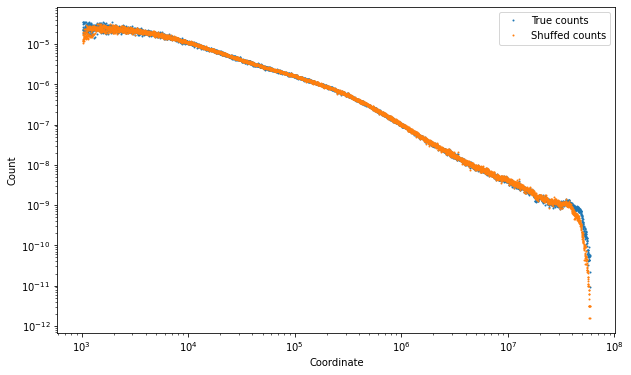

In [101]:
plt.figure(figsize=(10,6))
plt.plot(
    counts.value[:-1],
    np.histogram(np.abs(np.diff(small_points, axis=1).ravel()), bins=counts.value, density=True)[0],
    '.',
    ms=2,
    label="True counts"
)

plt.plot(
    counts.value[:-1],
    np.histogram(np.abs(np.diff(DS.new_points, axis=1).ravel()), bins=counts.value, density=True)[0],
    '.',
    ms=2,
    label="Shuffed counts"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Coordinate")
plt.ylabel("Count")
plt.legend()

In [106]:
pd.DataFrame(DS.new_points, columns=["start1", "start2"])\
    .to_csv("/Users/regevschweiger/Documents/matshuff_data/ela_19/points_magic_shuffled_20210330.txt", sep="\t", index=False)